In [2]:
from collections import namedtuple
import torch
import torch.nn.functional as F
import random
import math
import torch.nn as nn
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from utils import select_action, ReplayMemory, optimize_model, soft_update, load_rewards
import random
import math
from itertools import count
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
# load rewards
from main import GAMMA,LR,NETWORK,EPS_DECAY
hyper_params = [(eps_decay, gamma, lr, network) for eps_decay in EPS_DECAY
                    for gamma in GAMMA
                    for lr in LR
                    for network in NETWORK.keys()]

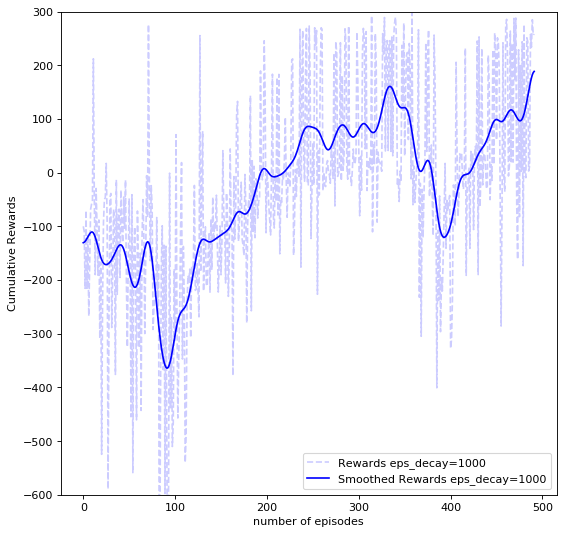

In [22]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d
# plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
[eps_decay,gamma,lr,network]=[1000, 0.999, 0.01, 'complex']

train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=lr, eps_decay=eps_decay,
                                                                                    gamma=gamma,
                                                                                    network=network)
# rewards_vector = np.array([None]*1000)
# ysmoothed_vector =np.array([None]*1000)
 
# train_rewards = load_rewards(train_rewards_path,'training_rewards')
# ysmoothed = gaussian_filter1d(train_rewards, sigma=6)
# rewards_vector[:len(train_rewards)] = train_rewards
# ysmoothed_vector[:len(ysmoothed)] = ysmoothed


# plt.plot(range(1000), rewards_vector,alpha = 0.5, color = 'blue', linestyle='dashed',label='Actual cumulative rewards')
# plt.plot(range(1000),ysmoothed_vector, color = 'blue',label = 'Smoothed curve')
# plt.title('')
# plt.xlabel('number of episodes')
# plt.ylabel('Cumulative Rewards')
# plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_rewards(ax, model_path, color, reward_option='training_rewards', extra_label=''):
    rewards_vector = np.array([None]*1000)
    ysmoothed_vector =np.array([None]*1000)

    rewards = load_rewards(model_path,reward_option)
    ysmoothed = gaussian_filter1d(rewards, sigma=6)
    rewards_vector[:len(rewards)] = rewards
    ysmoothed_vector[:len(ysmoothed)] = ysmoothed
    ax.plot(range(1000), rewards_vector,alpha = 0.2, color = color, linestyle='dashed',label='Rewards {extra_label}'.format(extra_label=extra_label))
    ax.plot(range(1000),ysmoothed_vector, color = color ,label = 'Smoothed Rewards {extra_label}'.format(extra_label=extra_label))
    ax.set_xlabel('number of episodes')
    ax.set_ylabel('Cumulative Rewards')
    ax.set_ylim(-600,300)
    ax.legend()
    
plot_rewards(ax, train_rewards_path, color='blue', extra_label='eps_decay=1000')


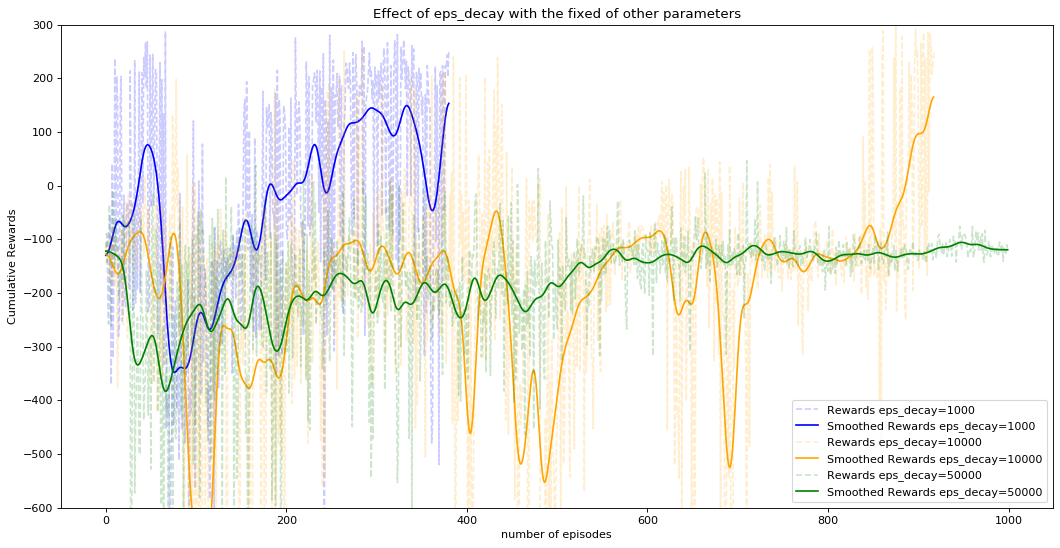

In [123]:
def plot_hyperparam(ax, param, fixed_param, reward_option='training_rewards', color_list=["blue", "orange", "green"],
                    set_title=True):
    param_list = {'gamma': GAMMA, 'lr': LR, 'network': NETWORK, 'eps_decay': EPS_DECAY}
    for p, color in zip(param_list.get(param), color_list):
        train_rewards_path = '{reward_option}_{lr}_{p}_{gamma}_{network}.pkl'.format(**fixed_param,
                                                                                     p=p,
                                                                                     reward_option=reward_option)
        plot_rewards(ax, train_rewards_path, color=color, reward_option=reward_option,
                     extra_label='{param}={v}'.format(param=param, v=p))
        if set_title:
            ax.set_title('Effect of {param} with the fixed of other parameters'.format(param=param))
            
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plot_hyperparam(ax, param='eps_decay', fixed_param = {'lr': 0.01,
                                                      'gamma': 0.999,
                                                      'network': 'simple'}, reward_option='training_rewards', color_list=["blue", "orange", "green"])

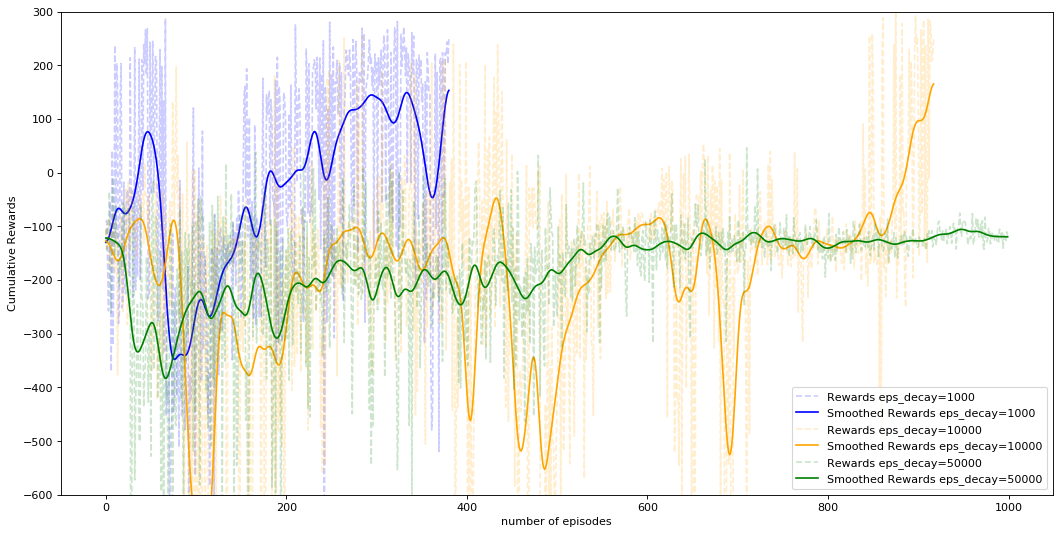

In [115]:
# plot eps_decay
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
color_list = ["blue", "orange", "green"]
fixed_param = {'lr': 0.01,
               'gamma': 0.999,
               'network': 'simple'}
for eps_decay,color in zip(EPS_DECAY,color_list):
#     train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=0.01, 
#                                                                                           eps_decay=eps_decay,
#                                                                                           gamma=0.999,
#                                                                                         network='simple')
    train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format( **fixed_param,
                                                                                              eps_decay=eps_decay)
    plot_rewards(ax, train_rewards_path, color=color, extra_label='eps_decay={v}'.format(v=eps_decay))



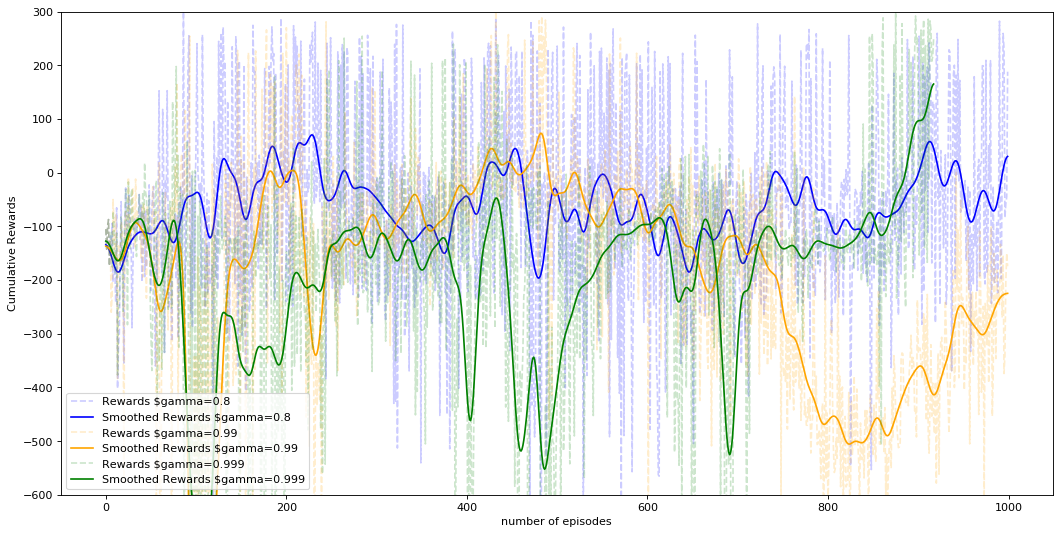

In [53]:
# plot gamma
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
color_list = ["blue", "orange", "green"]
for gamma,color in zip(GAMMA,color_list):
    train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=0.01, 
                                                                                          eps_decay=10000,
                                                                                          gamma=gamma,
                                                                                        network='simple')
    plot_rewards(ax, train_rewards_path, color=color, extra_label=r'\$gamma={v}'.format(v=gamma))



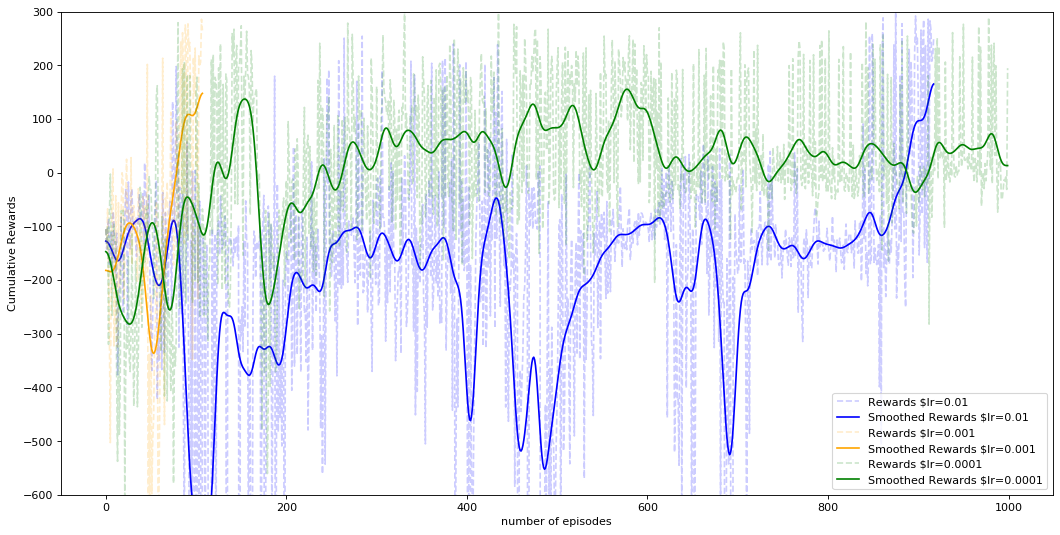

In [49]:
#plot learning rate
# plot gamma
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
color_list = ["blue", "orange", "green"]
for lr,color in zip(LR,color_list):
    train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=lr, 
                                                                                          eps_decay=10000,
                                                                                          gamma=0.999,
                                                                                        network='simple')
    plot_rewards(ax, train_rewards_path, color=color, extra_label=r'\$lr={v}'.format(v=lr))



In [65]:
# find best parameter combo for each network
# load the test time rewards
test_rewards_dict = {}
for (eps_decay, gamma, lr, network) in hyper_params:
    test_rewards_path = 'test_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=lr, 
                                                                                          eps_decay=eps_decay,
                                                                                          gamma=gamma,
                                                                                        network=network)
    test_rewards = load_rewards(test_rewards_path,'test_rewards')
    if network not in test_rewards_dict.keys():
        test_rewards_dict[network]={'_'.join([str(lr),str(eps_decay),str(gamma)]):test_rewards}
    else:
        test_rewards_dict[network].update({'_'.join([str(lr),str(eps_decay),str(gamma)]):test_rewards})
    
    


In [75]:
import pandas as pd
test_rewards_dict

,simple,medium,complex
0.01_1000_0.8,"[-401.0774095048541, -400.79313778863025, -255...","[-404.9150291071123, -352.30647920627996, -123...","[-400.43087162230586, -450.55147196462303, -40..."
0.001_1000_0.8,"[-230.7681189833355, 2.1258674740304286, -10.0...","[-400.48474950519994, 164.8520841325053, -400....","[49.662319343861604, -400.1023140300682, -400...."
0.0001_1000_0.8,"[56.37458848588163, -400.4186165168662, -18.85...","[-400.1639555481769, -400.7053197302896, -400....","[-65.31181744092544, 238.34681859508234, -1.10..."
0.01_1000_0.99,"[-159.551988087648, -196.98543884679998, -402....","[-128.82286487650865, -57.08040422083212, -93....","[-403.8159640486523, -404.099848013374, -407.0..."
0.001_1000_0.99,"[222.02744982592264, 255.6736353142198, 233.59...","[242.41763509473927, 276.6183197238612, 276.92...","[33.610808820678926, 211.58117655665416, 196.7..."
0.0001_1000_0.99,"[-29.895144707869065, 193.88586433313802, 46.2...","[209.16102472071583, 193.94479489052213, 184.9...","[207.52245577644013, -214.82354122442925, -25...."
0.01_1000_0.999,"[197.67372431454635, 192.24455297749316, 193.0...","[251.8975162852264, 201.29179994956826, 255.83...","[-370.29940950954864, 259.7447886382114, 69.98..."
0.001_1000_0.999,"[-232.14032759255667, 167.982282210467, 163.45...","[188.16918176462633, 220.4819404819554, 36.157...","[147.7476389122953, 220.92917067846275, 232.27..."
0.0001_1000_0.999,"[-28.522828856603198, 262.96736028768754, 219....","[-42.01553811102501, 182.6817549385978, 138.71...","[255.4408433791564, 153.05322547996929, 215.88..."
0.01_10000_0.8,"[-400.03919817141497, -215.75172254762185, -33...","[-405.4520583569219, -410.7553645415116, -405....","[-400.29286934636434, -60.866580855800024, -16..."


In [93]:
agg_rewards = {network:[(k,(np.array(v)>200).mean()) for k,v in param_dict.items()]
               for network, param_dict in test_rewards_dict.items()}

select_max_rewards = {}
for k,v in agg_rewards.items():
    ind = [avg_rewards for _, avg_rewards in v ].index(max([avg_rewards for _, avg_rewards in v ]))
    params = [float(i) for i in v[ind][0].split('_')]
    params.extend([k]) 
    select_max_rewards.update({k:params})
 

In [124]:
agg_rewards

{'simple': [('0.01_1000_0.8', 0.14),
  ('0.001_1000_0.8', 0.32),
  ('0.0001_1000_0.8', 0.09),
  ('0.01_1000_0.99', 0.0),
  ('0.001_1000_0.99', 0.74),
  ('0.0001_1000_0.99', 0.1),
  ('0.01_1000_0.999', 0.49),
  ('0.001_1000_0.999', 0.3),
  ('0.0001_1000_0.999', 0.64),
  ('0.01_10000_0.8', 0.21),
  ('0.001_10000_0.8', 0.21),
  ('0.0001_10000_0.8', 0.19),
  ('0.01_10000_0.99', 0.0),
  ('0.001_10000_0.99', 0.75),
  ('0.0001_10000_0.99', 0.07),
  ('0.01_10000_0.999', 0.13),
  ('0.001_10000_0.999', 0.16),
  ('0.0001_10000_0.999', 0.15),
  ('0.01_50000_0.8', 0.19),
  ('0.001_50000_0.8', 0.06),
  ('0.0001_50000_0.8', 0.19),
  ('0.01_50000_0.99', 0.0),
  ('0.001_50000_0.99', 0.0),
  ('0.0001_50000_0.99', 0.56),
  ('0.01_50000_0.999', 0.0),
  ('0.001_50000_0.999', 0.13),
  ('0.0001_50000_0.999', 0.0)],
 'medium': [('0.01_1000_0.8', 0.0),
  ('0.001_1000_0.8', 0.18),
  ('0.0001_1000_0.8', 0.14),
  ('0.01_1000_0.99', 0.1),
  ('0.001_1000_0.99', 0.78),
  ('0.0001_1000_0.99', 0.31),
  ('0.01_1000_0.9

{'simple': [0.001, 10000.0, 0.99, 'simple'], 'medium': [0.01, 1000.0, 0.999, 'medium'], 'complex': [0.001, 50000.0, 0.99, 'complex']}


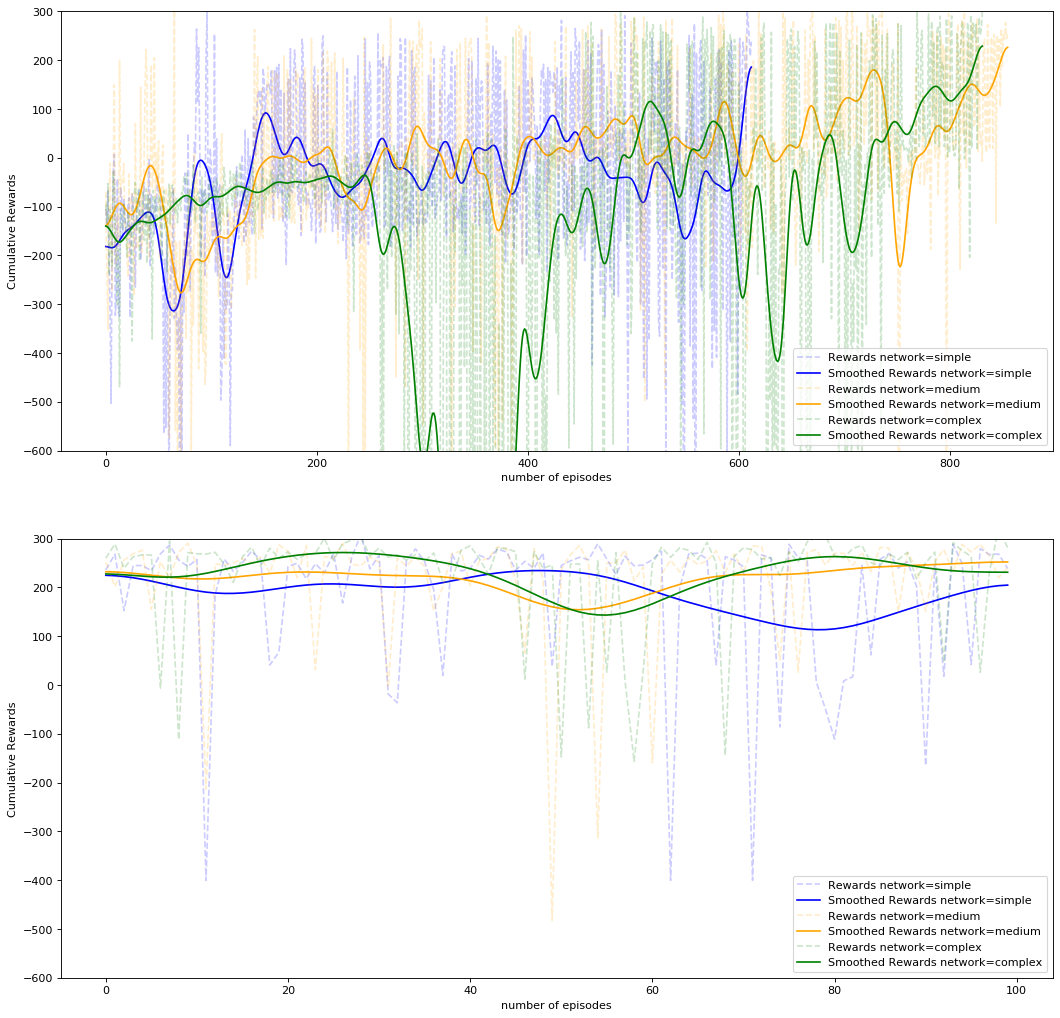

In [110]:
# plot the training reward for best parameters for each 
print (select_max_rewards) 
# for lr, eps_decay, gamma, network in select_max_rewards.values():
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
color_list = ["blue", "orange", "green"]
for (lr, eps_decay, gamma, network), color in zip(select_max_rewards.values(),color_list):
    eps_decay=int(eps_decay)
    train_rewards_path = 'training_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=lr, 
                                                                                          eps_decay=eps_decay,
                                                                                          gamma=gamma,
                                                                                        network=network)
    plot_rewards(ax1, train_rewards_path, color=color, reward_option='training_rewards', extra_label=r'network={v}'.format(v=network))
    
for (lr, eps_decay, gamma, network), color in zip(select_max_rewards.values(),color_list):
    eps_decay=int(eps_decay)
    test_rewards_path = 'test_rewards_{lr}_{eps_decay}_{gamma}_{network}.pkl'.format(lr=lr, 
                                                                                          eps_decay=eps_decay,
                                                                                          gamma=gamma,
                                                                                        network=network)
    plot_rewards(ax2, test_rewards_path, color=color, reward_option='test_rewards', extra_label=r'network={v}'.format(v=network))


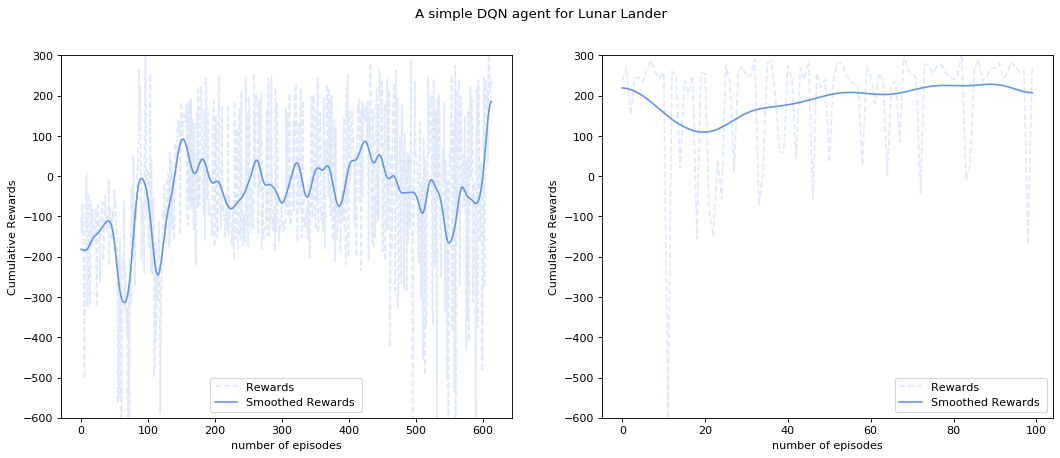

In [111]:
# plot for demo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('A simple DQN agent for Lunar Lander')
plot_rewards(ax1, 'demo_training_rewards.pkl', color='cornflowerblue', reward_option='training_rewards')
plot_rewards(ax2, 'demo_test_rewards.pkl', color='cornflowerblue', reward_option='test_rewards')
plt.savefig('plots/demo.png')


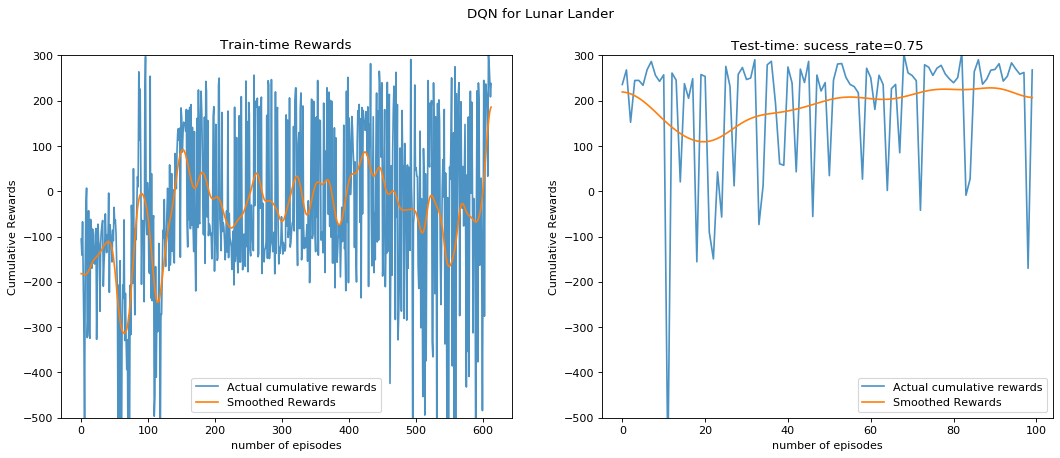

In [59]:
# Plot from demo
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

train_rewards_path = 'demo_training_rewards.pkl'
train_rewards = load_rewards(train_rewards_path,'training_rewards')
test_rewards_path = 'demo_test_rewards.pkl'
test_rewards = load_rewards(test_rewards_path,'test_rewards')
ysmoothed_train = gaussian_filter1d(train_rewards, sigma=6)
ysmoothed_test = gaussian_filter1d(test_rewards, sigma=6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('DQN for Lunar Lander')
ax1.plot(np.array(train_rewards),alpha = 0.8, label='Actual cumulative rewards')
ax1.plot(ysmoothed_train, label = 'Smoothed Rewards')
ax1.set_ylim(-500,300)
ax1.set_title('Train-time Rewards')
ax1.set_xlabel('number of episodes')
ax1.set_ylabel('Cumulative Rewards')
ax1.legend()

ax2.plot(np.array(test_rewards),alpha = 0.8, label='Actual cumulative rewards')
ax2.plot(ysmoothed_test, label = 'Smoothed Rewards')
ax2.set_ylim(-500,300)
ax2.set_title('Test-time: sucess_rate={p}'.format(p=(np.array(test_rewards)>200).mean()))
ax2.set_xlabel('number of episodes')
ax2.set_ylabel('Cumulative Rewards')
ax2.legend()



In [ ]:
#power smooth
# xnew = np.linspace(0, len(rewards), 10)
# spl = make_interp_spline(range(len(rewards)), rewards, k=3)  # type: BSpline
# power_smooth = spl(xnew)

# plt.plot(xnew,power_smooth)
# plt.show()

# gaussian smooth

In [54]:

hyper_params


[(1000, 0.8, 0.01, 'simple'),
 (1000, 0.8, 0.01, 'medium'),
 (1000, 0.8, 0.01, 'complex'),
 (1000, 0.8, 0.001, 'simple'),
 (1000, 0.8, 0.001, 'medium'),
 (1000, 0.8, 0.001, 'complex'),
 (1000, 0.8, 0.0001, 'simple'),
 (1000, 0.8, 0.0001, 'medium'),
 (1000, 0.8, 0.0001, 'complex'),
 (1000, 0.99, 0.01, 'simple'),
 (1000, 0.99, 0.01, 'medium'),
 (1000, 0.99, 0.01, 'complex'),
 (1000, 0.99, 0.001, 'simple'),
 (1000, 0.99, 0.001, 'medium'),
 (1000, 0.99, 0.001, 'complex'),
 (1000, 0.99, 0.0001, 'simple'),
 (1000, 0.99, 0.0001, 'medium'),
 (1000, 0.99, 0.0001, 'complex'),
 (1000, 0.999, 0.01, 'simple'),
 (1000, 0.999, 0.01, 'medium'),
 (1000, 0.999, 0.01, 'complex'),
 (1000, 0.999, 0.001, 'simple'),
 (1000, 0.999, 0.001, 'medium'),
 (1000, 0.999, 0.001, 'complex'),
 (1000, 0.999, 0.0001, 'simple'),
 (1000, 0.999, 0.0001, 'medium'),
 (1000, 0.999, 0.0001, 'complex'),
 (10000, 0.8, 0.01, 'simple'),
 (10000, 0.8, 0.01, 'medium'),
 (10000, 0.8, 0.01, 'complex'),
 (10000, 0.8, 0.001, 'simple'),
 

In [9]:
def select_action(state,
                  policy_net,
                  n_actions,
                  steps_done,
                  device,
                  eps_end,
                  eps_start,
                  eps_decay):
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
                    math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            # return torch.unique(policy_net(state).max(0)[1]).view(1, 1), steps_done
            return torch.argmax(policy_net(state), dim=1).view(1, 1), steps_done
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long), steps_done


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# optimize the model for each steps
# Optimize the model
def optimize_model(memory,
                   batch_size,
                   device,
                   policy_net,
                   target_net,
                   optimizer,
                   gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #     for param in policy_net.parameters():
    #         param.grad.data.clamp_(-1, 1)
    optimizer.step()


# soft update the weights
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    =======
        local model (PyTorch model): weights will be copied from
        target model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(),
                                         local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

class DQN(nn.Module):
    def __init__(self,
                 state_size,
                 action_size,
                 seed=None,
                 fc1_unit=16,
                 fc2_unit=8):
        super(DQN, self).__init__()
        if seed is not None:
            self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)



In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from utils import select_action, ReplayMemory, optimize_model, soft_update
import random
import math
from itertools import count
import matplotlib.pyplot as plt
import torch.nn as nn

# Global parameters
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 10000
n_actions = 4
GAMMA = 0.99
TARGET_UPDATE = 10
MEMORY_CAPACITY = 10000
BATCH_SIZE = 64
TAU = 0.1

# hyper parameters
LR = 0.001
N_EPISODES = 10


# The network
class DQN(nn.Module):
    def __init__(self,
                 state_size,
                 action_size,
                 seed,
                 fc1_unit=16,
                 fc2_unit=8):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


if __name__ == '__main__':
    # initiate the environment
    id = 'LunarLander-v2'
    env = gym.make(id).unwrapped
    n_actions = env.action_space.n

    # set seed
    random.seed(131)
    env.seed(131)

    # initiate the network
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(state_size=8,
                     action_size=4,
                     seed=131).to(device)
    target_net = DQN(state_size=8,
                     action_size=4,
                     seed=1).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # initiate the memory replayer and optimizer
    memory = ReplayMemory(MEMORY_CAPACITY)
    # optimizer = optim.RMSprop(policy_net.parameters())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)

    # initiate the global steps
    steps_done = 0

    # Here my watch started
    rewards = []
    for i_episode in range(N_EPISODES):
        cumulative_reward = 0
        state = env.reset()
        state = torch.tensor([state])
        for t in count():
            action, steps_done = select_action(state=state,
                                               policy_net=policy_net,
                                               n_actions=n_actions,
                                               steps_done=steps_done,
                                               device=device,
                                               eps_end=EPS_END,
                                               eps_start=EPS_START,
                                               eps_decay=EPS_DECAY)

            state_next, reward, done, _ = env.step(action.item())
            # env.render()
            cumulative_reward = cumulative_reward + reward
            # convert it to tensor
            state_next = torch.tensor([state_next], device=device)
            reward = torch.tensor([reward], device=device, dtype=torch.float32)
            memory.push(state,
                        action,
                        state_next,
                        reward)
            state = state_next

            # every step update the weights in the policy net
            optimize_model(memory=memory,
                           batch_size=BATCH_SIZE,
                           device=device,
                           policy_net=policy_net,
                           target_net=target_net,
                           optimizer=optimizer,
                           gamma=GAMMA)

            if done:
                break

        rewards.append(cumulative_reward)
        rate = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        print('cumulative reward for episode {n_ep} is {cum_reward}; With the epsilon: {eps}'. \
              format(n_ep=i_episode,
                     cum_reward=cumulative_reward,
                     eps=rate))

        # update the target net after a while
        if i_episode % TARGET_UPDATE == 0:
            # If want the soft update the weights
            #         soft_update(local_model=policy_net, target_model=target_net, tau=TAU)
            target_net.load_state_dict(policy_net.state_dict())
            print("target net weights updated")
    plt.plot(np.array(rewards))
    plt.savefig('plots/cumulative_reward.png')


In [24]:
# create a test set
id = 'LunarLander-v2'
env = gym.make(id).unwrapped
n_actions = env.action_space.n
steps_done=0        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env.seed(12306)
N_TEST_EPISODES = 1 
def act_as_policy(state,
                  policy_net,
                  steps_done):
    with torch.no_grad():
    # t.max(1) will return largest column value of each row.
    # second column on max result is index of where max element was
    # found, so we pick action with the larger expected reward.
        return torch.argmax(policy_net(state), dim=1).view(1, 1), steps_done

    
for i_episode in range(N_TEST_EPISODES):
        cumulative_reward = 0
        state = env.reset()
        state = torch.tensor([state])
        for t in count():
            action, steps_done = act_as_policy(state=state,
                                               policy_net=policy_net,
                                               steps_done=steps_done)

            state_next, reward, done, _ = env.step(action.item())
            # env.render()
            cumulative_reward = cumulative_reward + reward
            # convert it to tensor
            state_next = torch.tensor([state_next], device=device)
            state = state_next
            if done:
                break

        rewards.append(cumulative_reward)

KeyboardInterrupt: 

In [60]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [64]:
from utils import print_param

ImportError: cannot import name 'print_param' from 'utils' (/Users/shayne.zhou/Documents/learning/GT/Reinforment Learning/7642Spring2020xzhou94/project2/utils.py)

In [63]:
from multiprocessing import Pool

hyper_params = [(eps_decay, gamma, lr, network) for eps_decay in EPS_DECAY
                                 for gamma in GAMMA
                                 for lr in LR
                                 for network in NETWORK.keys()]
pool = Pool(2)
pool.starmap(print_param, hyper_params)

KeyboardInterrupt: 

In [61]:
#!/usr/bin/env python3
from functools import partial
from itertools import repeat
from multiprocessing import Pool, freeze_support

def func(a, b):
    return a + b

def main():
    a_args = [1,2,3]
    second_arg = 1
    with Pool() as pool:
        L = pool.starmap(func, [(1, 1), (2, 1), (3, 1)])
        M = pool.starmap(func, zip(a_args, repeat(second_arg)))
        N = pool.map(partial(func, b=second_arg), a_args)
        assert L == M == N

if __name__=="__main__":
    freeze_support()
    main()

KeyboardInterrupt: 

In [55]:
hyper_params

[(1000, 0.8, 0.01, 'simple'),
 (1000, 0.8, 0.01, 'medium'),
 (1000, 0.8, 0.01, 'complex'),
 (1000, 0.8, 0.001, 'simple'),
 (1000, 0.8, 0.001, 'medium'),
 (1000, 0.8, 0.001, 'complex'),
 (1000, 0.8, 0.0001, 'simple'),
 (1000, 0.8, 0.0001, 'medium'),
 (1000, 0.8, 0.0001, 'complex'),
 (1000, 0.99, 0.01, 'simple'),
 (1000, 0.99, 0.01, 'medium'),
 (1000, 0.99, 0.01, 'complex'),
 (1000, 0.99, 0.001, 'simple'),
 (1000, 0.99, 0.001, 'medium'),
 (1000, 0.99, 0.001, 'complex'),
 (1000, 0.99, 0.0001, 'simple'),
 (1000, 0.99, 0.0001, 'medium'),
 (1000, 0.99, 0.0001, 'complex'),
 (1000, 0.999, 0.01, 'simple'),
 (1000, 0.999, 0.01, 'medium'),
 (1000, 0.999, 0.01, 'complex'),
 (1000, 0.999, 0.001, 'simple'),
 (1000, 0.999, 0.001, 'medium'),
 (1000, 0.999, 0.001, 'complex'),
 (1000, 0.999, 0.0001, 'simple'),
 (1000, 0.999, 0.0001, 'medium'),
 (1000, 0.999, 0.0001, 'complex'),
 (10000, 0.8, 0.01, 'simple'),
 (10000, 0.8, 0.01, 'medium'),
 (10000, 0.8, 0.01, 'complex'),
 (10000, 0.8, 0.001, 'simple'),
 

In [35]:
EPS_DECAY = [1000, 10000, 50000]
GAMMA = [0.8, 0.99, 0.999]
LR = [0.01, 0.001, 0.0001]
NETWORK = {'simple': (16,8),
           'medium': (64,16),
           'complex': (256, 128)}

In [48]:
hyper_params = np.array([(eps_decay, gamma, lr, network) for eps_decay in EPS_DECAY
                                 for gamma in GAMMA
                                 for lr in LR
                                 for network in NETWORK.keys()]).reshape(3,-1,4)

In [51]:
hyper_params[0]

array([['1000', '0.8', '0.01', 'simple'],
       ['1000', '0.8', '0.01', 'medium'],
       ['1000', '0.8', '0.01', 'complex'],
       ['1000', '0.8', '0.001', 'simple'],
       ['1000', '0.8', '0.001', 'medium'],
       ['1000', '0.8', '0.001', 'complex'],
       ['1000', '0.8', '0.0001', 'simple'],
       ['1000', '0.8', '0.0001', 'medium'],
       ['1000', '0.8', '0.0001', 'complex'],
       ['1000', '0.99', '0.01', 'simple'],
       ['1000', '0.99', '0.01', 'medium'],
       ['1000', '0.99', '0.01', 'complex'],
       ['1000', '0.99', '0.001', 'simple'],
       ['1000', '0.99', '0.001', 'medium'],
       ['1000', '0.99', '0.001', 'complex'],
       ['1000', '0.99', '0.0001', 'simple'],
       ['1000', '0.99', '0.0001', 'medium'],
       ['1000', '0.99', '0.0001', 'complex'],
       ['1000', '0.999', '0.01', 'simple'],
       ['1000', '0.999', '0.01', 'medium'],
       ['1000', '0.999', '0.01', 'complex'],
       ['1000', '0.999', '0.001', 'simple'],
       ['1000', '0.999', '0.001',

In [47]:
hyper_params.shape

(81, 4)

In [ ]:
import numpy as np
import gym
import Box2D
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import random
import math
from itertools import count
import matplotlib.pyplot as plt 
# test lunar lander
from gym.envs.box2d.lunar_lander import demo_heuristic_lander

In [ ]:
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
id='LunarLander-v2'
env = gym.make(id).unwrapped
demo_heuristic_lander(env, render=False)

In [ ]:
# write functions

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
#     eps_threshold = max(EPS_START*(EPS_DECAY**steps_done),EPS_END)
    steps_done += 1
    if sample > eps_threshold:
        
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             a = torch.unique(actions.max(0)[1]).view(1, 1)
            b = torch.argmax(policy_net(state), dim=1).view(1, 1)
#             print ("actions out of the network {actions}, action taken: {b}".format(actions=actions,b=b))
            return b
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


# change the array to tensor
# env.reset()
# s_test, r_test, done, _ = env.step(0)
# select_action(torch.from_numpy(s_test))

In [ ]:
# replay memories
# it will at maximum store Capacity Memory, by replacing the oldest one to the new ones.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# # test it
# test_RM = ReplayMemory(4)
# env.reset()
# s, r_test, done, _ = env.step(0)
# for i in range(7):
#     a = select_action(torch.tensor(s_test))
#     s_next, r, done, _ = env.step(a.item())
    
#     test_RM.push(torch.tensor([s], device=device), 
#                  a, 
#                  torch.tensor([s_next], device=device), 
#                  torch.tensor([r],device=device))
#     print (test_RM.position)
#     s = s_next
# print (test_RM.memory)
# # test sample
# test_trans= test_RM.sample(2)
# batch = Transition(*zip(*test_trans))
# batch.next_state

In [ ]:
def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

In [6]:
# The network
class DQN(nn.Module):
    def __init__(self, 
                 state_size,
                 action_size, 
                 seed, 
                 fc1_unit=512,
                 fc2_unit=256):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         return F.softmax(self.fc3(x), dim=0)
        return self.fc3(x)
    
# test it 
# policy_net = DQN(state_size=8,
#                  action_size=4, 
#                  seed=131).to(device)

# play with simple nets to make sure it works for target and policy


NameError: name 'nn' is not defined

In [ ]:
# Optimize the model
def optimize_model():
    global steps_done
#     print (len(memory),BATCH_SIZE )
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)

    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     print (target_net(non_final_next_states).max(1)[0])
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
#     loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    print ("loss is: {loss}".format(loss=loss))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()
#     print ("first elem parameter is:{elem}".format(elem=list(policy_net.parameters())[0][0]))

    

    
# optimize_model() 

In [ ]:
## put things together

# define global variables
steps_done = 0 
EPS_START = 0.9
EPS_END = 0.1
# EPS_DECAY = 0.999
EPS_DECAY = 2000
n_actions = 4
GAMMA = 0.99
TARGET_UPDATE = 8
MEMORY_CAPACITY = 50000
BATCH_SIZE=64
TAU = 0.1  

# Initalized network and memory replayer
policy_net = DQN(state_size=8,
                 action_size=4, 
                 seed=131).to(device)
target_net = DQN(state_size=8,
                 action_size=4, 
                 seed=1).to(device)
target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()

random.seed(131)
env.seed(131)

memory = ReplayMemory(MEMORY_CAPACITY)
# optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

num_episodes = 250
rewards = []
for i_episode in range(num_episodes):
    cumulative_reward = 0
    state = env.reset()
    state = torch.tensor([state])
    for t in count():
        action = select_action(state)
        state_next, reward, done, _ = env.step(action.item())
        cumulative_reward = cumulative_reward + reward
        # convert it to tensor
        state_next =torch.tensor([state_next], device=device)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        memory.push( state, 
                     action, 
                     state_next, 
                     reward)
        state = state_next
        optimize_model()
        if done:
            break
    rewards.append(cumulative_reward)
    rate=EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
#     rate = max(EPS_START*(EPS_DECAY**steps_done),EPS_END)
    print ('cumulative reward for episode {n_ep} is {cum_reward}; With the epsilon: {eps}'.format(n_ep=i_episode,
                                                                         cum_reward=cumulative_reward,
                                                                                                 eps=rate))
    # implement early stop to prevent over training
    if np.min(rewards[-5:]) >= 200:
        break
    
    # update the target net after a while
    if i_episode % TARGET_UPDATE == 0:
#         soft_update(local_model=policy_net, target_model=target_net, tau=TAU)
        target_net.load_state_dict(policy_net.state_dict())
        print("target net weights updated")
        print ("steps done at: {st}".format(st=steps_done))
        
    

In [ ]:
# plot the cumulative the rewards
plt.plot(rewards)
# plt.plot(np.array(rewards).reshape(5, -1).mean(axis = 0))

In [ ]:
transitions = memory.sample(BATCH_SIZE)
batch = Transition(*zip(*transitions))

# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                      batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)

reward_batch = torch.cat(batch.reward)

# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# columns of actions taken. These are the actions which would've been taken
# for each batch state according to policy_net
state_action_values = policy_net(state_batch).gather(1, action_batch)

# Compute V(s_{t+1}) for all next states.
# Expected values of actions for non_final_next_states are computed based
# on the "older" target_net; selecting their best reward with max(1)[0].
# This is merged based on the mask, such that we'll have either the expected
# state value or 0 in case the state was final.
next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     print (target_net(non_final_next_states).max(1)[0])
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch

# Compute Huber loss
loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

# Optimize the model
optimizer.zero_grad()
loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
optimizer.step()


In [ ]:
env.action_space.n